### !/usr/bin/env python
# coding: utf-8

# ## Spiking Transformer Implementation

# In[1]:


#imports x
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
import torch
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter
from timm.models.layers import to_2tuple, trunc_normal_, DropPath
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

# ### Import CIFAR datasets

# In[2]:


# dataloader arguments
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
writer = SummaryWriter()

# In[3]:


# Define a transform
transform = transforms.Compose([
            transforms.ToTensor()])

batch_size = 4

CIFAR_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
CIFAR_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = CIFAR_train.classes

#reduce datasize
# subsets_train = list(range(0, len(CIFAR_train), 10))
# subsets_test = list(range(0, len(CIFAR_test), 10))

CIFAR_train = torch.utils.data.Subset(CIFAR_train, subsets_train)
CIFAR_test = torch.utils.data.Subset(CIFAR_test, subsets_test)

train_loader = DataLoader(CIFAR_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(CIFAR_test,batch_size=batch_size,shuffle=True)

In [2]:
H, W = 32, 32


train_iter = iter(train_loader)
data, targets = next(train_iter)
# for data, targets in train_iter:
#     for i in range(0,4):
#         plt.subplot(1, 4, i+1)
#         plt.imshow(np.rot90(np.array(data[i]).T, k=-1))
#         plt.title(classes[targets[i]])
#     break
    
    


# ## Define the network

# ### SPS layers
# Given input image $I \in (T, C, H, W)$ where $T$ is the time step, $C$ is the color channel, $H$ and $W$ are the height and width of the image. The spikeing patch splitting (SPS) linearly project $I$ to a $D$ dimensional spike-form feature vector and splits it into a sequence of $N$ flattened spike-form patches $x$. 
# $$ x = SPS(I) \\ I \in R^{T*C*H*W}, x \in R^{T*N*D}$$

# In[6]:


# Temporal Dynamics
beta = 1.0
spike_grad = surrogate.sigmoid(slope=4)


# In[7]:


class SPS(nn.Module):
    def __init__(self, img_size_h=32, img_size_w=32, patch_size=4,
                 in_channels=3, embed_dims=256, beta = 1.0):
        super().__init__()
        self.image_size = [img_size_h, img_size_w]
      
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size
        self.C = in_channels
        self.H, self.W = self.image_size[0] // patch_size[0], self.image_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj_conv = nn.Conv2d(in_channels, embed_dims//8, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn = nn.BatchNorm2d(embed_dims//8)
        self.proj_lif = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold = 1, init_hidden=True, output = True)

        self.proj_conv1 = nn.Conv2d(embed_dims//8, embed_dims//4, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn1 = nn.BatchNorm2d(embed_dims//4)
        self.proj_lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True, output = True)

        self.proj_conv2 = nn.Conv2d(embed_dims//4, embed_dims//2, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn2 = nn.BatchNorm2d(embed_dims//2)
        self.proj_lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True, output = True)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.proj_conv3 = nn.Conv2d(embed_dims//2, embed_dims, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn3 = nn.BatchNorm2d(embed_dims)
        self.proj_lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True, output = True)
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.rpe_conv = nn.Conv2d(embed_dims, embed_dims, kernel_size=3, stride=1, padding=1, bias=False)
        self.rpe_bn = nn.BatchNorm2d(embed_dims)
        self.rpe_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True, output = True)

    def forward(self, x):
        # #Do we need to init mem here?
        
        T, B, C, H, W = x.shape
        x = self.proj_conv(x.flatten(0, 1)) # have some fire value
        cur0 = self.proj_bn(x).reshape(T, B, -1, H, W).contiguous()
        spk0, mem = self.proj_lif(cur0)
        spk0 = spk0.flatten(0, 1).contiguous()

        x = self.proj_conv1(spk0)
        cur1 = self.proj_bn1(x).reshape(T, B, -1, H, W).contiguous()
        spk1, mem  = self.proj_lif1(cur1)
        spk1 = spk1.flatten(0, 1).contiguous()

        x = self.proj_conv2(spk1)
        cur2 = self.proj_bn2(x).reshape(T, B, -1, H, W).contiguous()
        spk2, mem = self.proj_lif2(cur2)
        spk2 = spk2.flatten(0, 1).contiguous()
        x = self.maxpool2(spk2)

        x = self.proj_conv3(x)
        cur3 = self.proj_bn3(x).reshape(T, B, -1, H//2, W//2).contiguous()
        spk3, mem  = self.proj_lif3(cur3)
        spk3  = spk3.flatten(0, 1).contiguous()
        x = self.maxpool3(spk3)

        x_feat = x.reshape(T, B, -1, H//4, W//4).contiguous()
        x = self.rpe_conv(x)
        cur4 = self.rpe_bn(x).reshape(T, B, -1, H//4, W//4).contiguous()
        spk4, mem  = self.rpe_lif(cur4)
        spk4 = spk4 + x_feat

        spk4 = spk4.flatten(-2).transpose(-1, -2)  # T,B,N,C
        return spk4


# In[8]:


data, targets = next(train_iter)

In [3]:
data.shape

torch.Size([4, 3, 32, 32])

/tmp/ipykernel_340979/2461177339.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  plt.imshow(np.rot90(data[0].T, k = -1))


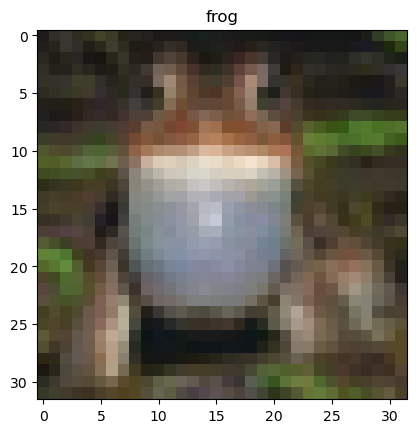

In [4]:
plt.imshow(np.rot90(data[0].T, k = -1))
plt.title(classes[targets[0]])
sps = SPS(H,W,in_channels=3)
sps_out = sps(data[None,:])

In [5]:
sps_out.detach().numpy().shape

(1, 4, 64, 256)

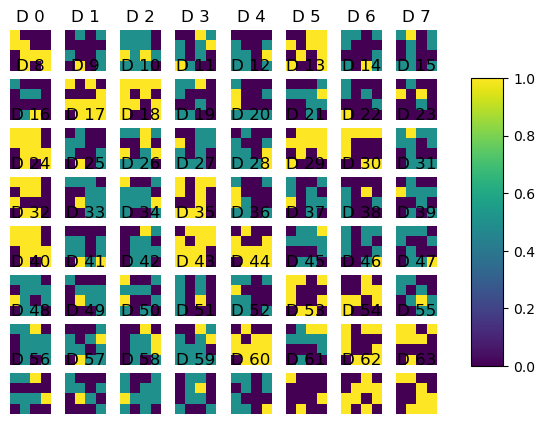

In [6]:
sps_out_patches = sps_out[0,0,0:4,:].detach().numpy().reshape((64,4,4))
for i in range(0,64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sps_out_patches[i,:,:])
    plt.title("D {0}".format(i))
    plt.axis('off')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.2, 0.05, 0.6])
plt.colorbar(cax=cax)

In [7]:
# ### Vanilla Self-Attention 
# Given input feature sequence $ X \in R^{T*N*D}$, the VSA in ViT has three float-point key component, query(Q_F), key(K_F), and value(V_F) which are calculated by learnable linear matrices $W_Q, W_K, W_V \in R^{D*D}$ and $X$:
# $$ Q_F = XW_Q, K_F = XW_K, V_F = XW_V $$
# where $F$ denotes the float-point form. The output of vanilla self-attention can be computed as:
# $$VSA(Q_F, K_F, V_F) = Softmax(\frac{Q_F K^{T}_F}{\sqrt{d}})$$

# ### Spiking Self-Attention Mechanism
# The query(Q), key(K), and value(V) are computed through learnable matrices. They become spiking sequences via different spike neuron layers:
# $$Q = SN_Q(BN(XW_Q)) \\ K = SN_K(BN(XW_K)) \\ V = SN_V(BN(XW_V))$$
# where $Q, K, V \in R^{T*N*D}$. 
# A scaling factor s is added to control the large value of the matrix multiplication result. The spike-friendly SSA is defined as:
# $$SSA' = (Q, K, V) = SN(Q,K^T, V*s) \\ SSA (Q, K, V) = SN(BN(Linear(SSA'(Q, K, V))))$$
#   

# In[13]:


class SSA(nn.Module):
    def __init__(self, dim, num_heads=4, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
        self.dim = dim
        self.num_heads = num_heads
        self.scale = 0.125
        self.q_linear = nn.Linear(dim, dim)
        self.q_bn = nn.BatchNorm1d(dim)
        self.q_lif =snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True)

        self.k_linear = nn.Linear(dim, dim)
        self.k_bn = nn.BatchNorm1d(dim)
        self.k_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True)

        self.v_linear = nn.Linear(dim, dim)
        self.v_bn = nn.BatchNorm1d(dim)
        self.v_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True)
        #scaling factor s? 
        #default threshold = 1.0, attn_lif threshold = 0.5 
        self.attn_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 0.5, init_hidden=True)

        self.proj_linear = nn.Linear(dim, dim)
        self.proj_bn = nn.BatchNorm1d(dim)
        self.proj_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True)

    def forward(self, x):
        T,B,N,C = x.shape

        x_for_qkv = x.flatten(0, 1)  # TB, N, C
        q_linear_out = self.q_linear(x_for_qkv)  # [TB, N, C]
        cur_q = self.q_bn(q_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        spk_q = self.q_lif(cur_q)
        q = spk_q.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        k_linear_out = self.k_linear(x_for_qkv)
        cur_k = self.k_bn(k_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T,B,C,N).contiguous()
        spk_k = self.k_lif(cur_k)
        k = spk_k.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        v_linear_out = self.v_linear(x_for_qkv)
        cur_v = self.v_bn(v_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T,B,C,N).contiguous()
        spk_v = self.v_lif(cur_v)
        v = spk_v.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        attn = (q @ k.transpose(-2, -1)) * self.scale
        x = attn @ v
        cur_s = x.transpose(2, 3).reshape(T, B, N, C).contiguous()
        spk_s = self.attn_lif(cur_s)
        spk_s = spk_s.flatten(0, 1)
        spk_p= self.proj_lif(self.proj_bn(self.proj_linear(spk_s).transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C))
        return spk_p


# In[14]:


# ssa = SSA(dim = 384)
# ssa_out = ssa(sps_out)


# In[15]:


# ssa_out.detach().numpy().shape


# In[16]:


# plt.imshow(ssa_out[0,0].detach().numpy())
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.4, 0.02, 0.2])
# plt.colorbar(cax=cax)


# In[17]:


# ssa_out_patches = ssa_out[0,0,0,:].detach().numpy().reshape((24,4,4))
# for i in range(0,24):
#     plt.subplot(4, 6, i+1)
#     plt.imshow(ssa_out_patches[i,:,:])
#     plt.title("D {0}".format(i))
#     plt.axis('off')
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.2, 0.05, 0.6])
# plt.colorbar(cax=cax)


# ### MLP with batch normalization

# In[18]:


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1_linear = nn.Linear(in_features, hidden_features)
        self.fc1_bn = nn.BatchNorm1d(hidden_features)
        self.fc1_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True)

        self.fc2_linear = nn.Linear(hidden_features, out_features)
        self.fc2_bn = nn.BatchNorm1d(out_features)
        self.fc2_lif = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold = 1, init_hidden=True)


        self.c_hidden = hidden_features
        self.c_output = out_features

    def forward(self, x):
        
        #Time step, Batch size, 
        T,B,N,C = x.shape
        
        x_ = x.flatten(0, 1)
        x = self.fc1_linear(x_)
        cur1 = self.fc1_bn(x.transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, self.c_hidden).contiguous()
        spk1 = self.fc1_lif(cur1)

        x = self.fc2_linear(spk1.flatten(0,1))
        cur2 = self.fc2_bn(x.transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        spk2 = self.fc2_lif(cur2)
        #print("MLP", spk2)
        return spk2


# In[19]:


# mlp = MLP(in_features=384)
# mlp_out = mlp(ssa_out)


# ### Encoder block 
# The embedded patches are passed into L-block Spikformer encoder. Similar to a standard Vit encoder block, a spikformer encoder block consists of a spiking self attention (SSA) and an MLP block. Residual connections are applied in botht the SSA and MLP block. 
# $$X'_l = SSA(X_{l-1}) + X_{l-1} \quad\quad X'_l \in R^{T*N*D}, l = 1...L\\ X_l = MLP(X'_l) + X'_l \quad\quad X_l \in R^{T*N*D}, l = 1...L$$

# In[20]:


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = SSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        #residual connection
        x_attn = self.attn(x)
        x = x + x_attn
        x = x + self.mlp(x)
        return x


# ### Spikformer
# A global avergae-pooling (GAP) is utilized on the processed feature from spikformerr encoder and outputs the D-dimension feature which will be sent to the fully connected layer classfication head to output the prediction Y. 
# $$Y = CH(GAP(X_L))$$
# 

# In[21]:


class Spikeformer(nn.Module):
    def __init__(self, img_size_h = 32, img_size_w = 32, patch_size = 4, 
                 in_channels=3, num_classes=10, embed_dims=256, num_heads=2, 
                 mlp_ratios = 4, qkv_bias = False, qk_scale = None, drop_rate=0., 
                 attn_drop_rate = 0., norm_layer=nn.LayerNorm, depths = 1, sr_ratios=1.,T = 12):
        super().__init__()
        self.T = T
        self.num_classes = num_classes
        self.depths = depths
        
        patch_embed = SPS(img_size_h=img_size_h,
                                 img_size_w=img_size_w,
                                 patch_size=patch_size,
                                 in_channels=in_channels,
                                 embed_dims=embed_dims)
        block = nn.ModuleList([Block(dim=embed_dims, num_heads=num_heads, mlp_ratio=mlp_ratios, 
                                     qkv_bias=qkv_bias,qk_scale=qk_scale, drop=drop_rate, 
                                     attn_drop=attn_drop_rate, norm_layer=norm_layer, 
                                     sr_ratio=sr_ratios) for j in range(depths)])
        setattr(self, f"patch_embed", patch_embed)
        setattr(self, f"block", block)
        # classification head
        self.head = nn.Linear(embed_dims, num_classes) if num_classes > 0 else nn.Identity()
        self.lif = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold = 1, init_hidden=True, output = True)
        self.apply(self._init_weights)
        
    def _get_pos_embed(self, pos_embed, patch_embed, H, W):
        if H * W == self.patch_embed1.num_patches:
            return pos_embed
        else:
            return F.interpolate(
                pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
                size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):

        block = getattr(self, f"block")
        patch_embed = getattr(self, f"patch_embed")

        x = patch_embed(x)
        for blk in block:
            x = blk(x)
        return x.mean(2)

    def forward(self, x):
    
        # data = spikegen.rate(x,self.T)
        spk_rec = []
        mem_rec = []
        data = (x.unsqueeze(0)).repeat(self.T, 1, 1, 1, 1)
        for q in data:
            x = self.forward_features(q[None,:])
            cur = self.head(x.mean(0))
            spk, mem = self.lif(cur)
            spk_rec.append(spk)
            mem_rec.append(mem)
        return torch.stack(spk_rec,dim=0), torch.stack(mem_rec, dim=0)


# In[22]:


#send the model weight to gpub
net = Spikeformer()
if torch.cuda.is_available():
    net.cuda()

In [8]:
out = net.block[0](net.patch_embed(data[None,:].to(device)))

In [9]:
out.shape

torch.Size([1, 4, 64, 256])

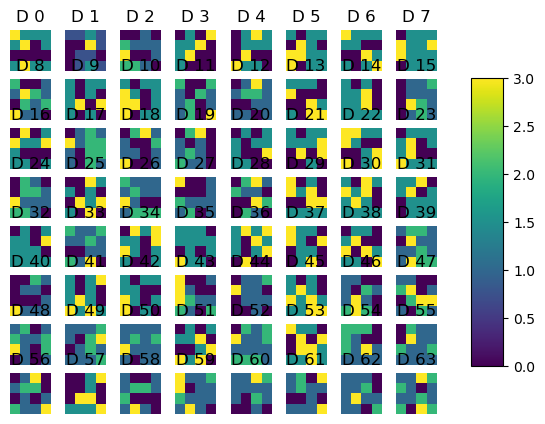

In [10]:
out_patches = out[0,0,0:4,:].cpu().detach().numpy().reshape((64,4,4))
for i in range(0,64):
    plt.subplot(8, 8, i+1)
    plt.imshow(out_patches[i,:,:])
    plt.title("D {0}".format(i))
    plt.axis('off')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.2, 0.05, 0.6])
plt.colorbar(cax=cax)

In [11]:
net(data.to(device))

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],
 
         [[0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
          [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
          [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1., 1., 0., 0., 0., 1.]],
 
         [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
          [0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],


In [12]:



summary(net)



def correct_pred(Y, targets):
    Y = torch.argmax(Y, axis=1)
    return torch.sum(Y==targets).detach().cpu().item()


# In[26]:


def batch_accuracy(train_loader, net):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()
        
        train_loader = iter(train_loader)
        for batch in tqdm(train_loader):
            data, targets = batch
            data = data.to(device)
            targets = targets.to(device)
            
            utils.reset(net)
            spk_rec, mem_rec = net(data)
            
            _, idx = spk_rec.sum(dim=0).max(1)
                
            acc = np.mean((targets == idx).detach().cpu().numpy())
            
    return acc


# In[ ]:


# test_acc = batch_accuracy(test_loader, net)

Layer (type:depth-idx)                   Param #
├─SPS: 1-1                               --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─Leaky: 2-3                        --
|    └─Conv2d: 2-4                       18,432
|    └─BatchNorm2d: 2-5                  128
|    └─Leaky: 2-6                        --
|    └─Conv2d: 2-7                       73,728
|    └─BatchNorm2d: 2-8                  256
|    └─Leaky: 2-9                        --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      294,912
|    └─BatchNorm2d: 2-12                 512
|    └─Leaky: 2-13                       --
|    └─MaxPool2d: 2-14                   --
|    └─Conv2d: 2-15                      589,824
|    └─BatchNorm2d: 2-16                 512
|    └─Leaky: 2-17                       --
├─ModuleList: 1-2                        --
|    └─Block: 2-18                       --
|    |    └─LayerNorm: 3-1               512
|  

In [15]:
test_acc = batch_accuracy(test_loader, net)
print(f"The total accuracy on the test set is: {test_acc*100:.2f}%")

100%|█████████████████████████████████████████| 250/250 [00:09<00:00, 25.04it/s]

The total accuracy on the test set is: 0.25%


In [14]:
net(data.to(device)), targets

((tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
  
          [[0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
           [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
           [0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],
  
          [[0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 1., 0., 0.

In [16]:

# ### Training

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
loss = nn.CrossEntropyLoss()
N_EPOCHS = 5
num_steps = 4

loss_hist = []
test_loss_hist = []


# Outer training loop
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    for batch in tqdm(train_loader, leave=False):
        data, targets = batch
        data, targets = data.to(device), targets.to(device)
        
        #Initialize hidden states at t = 0
        net.train()
        utils.reset(net)
        
        spk_rec, mem_rec = net(data)
        
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        print("Loss: ",loss_val.item())
        
    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {loss_val.item():.4f}")
        
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        net.eval()
        for batch in tqdm(test_loader, desc="Testing"):
            test_data, test_targets = batch
            test_data, test_targets = data.to(device), targets.to(device)
            
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
                
            test_loss_hist.append(test_loss.item())


            acc = batch_accuracy(test_data, test_targets)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {acc * 100:.2f}%")
        

  0%|                                          | 3/1250 [00:00<02:03, 10.09it/s]

Loss:  9.992311477661133
Loss:  9.210844039916992
Loss:  9.203815460205078


  0%|▏                                         | 5/1250 [00:00<01:56, 10.69it/s]

Loss:  9.211856842041016
Loss:  9.197086334228516
Loss:  9.2040433883667


  1%|▎                                         | 9/1250 [00:00<01:54, 10.85it/s]

Loss:  9.20470142364502
Loss:  9.21125602722168
Loss:  9.217926025390625


  1%|▎                                        | 11/1250 [00:01<01:52, 11.01it/s]

Loss:  9.202641487121582
Loss:  9.22005844116211
Loss:  9.225797653198242


  1%|▍                                        | 15/1250 [00:01<01:52, 11.01it/s]

Loss:  9.198482513427734
Loss:  9.190550804138184
Loss:  9.202392578125


  1%|▌                                        | 17/1250 [00:01<01:51, 11.02it/s]

Loss:  9.208735466003418
Loss:  9.218866348266602
Loss:  9.217052459716797


  2%|▋                                        | 21/1250 [00:01<01:50, 11.07it/s]

Loss:  9.210028648376465
Loss:  9.212227821350098
Loss:  9.175101280212402


  2%|▊                                        | 23/1250 [00:02<01:51, 11.05it/s]

Loss:  9.19405746459961
Loss:  9.205106735229492
Loss:  9.197868347167969


  2%|▉                                        | 27/1250 [00:02<01:51, 10.96it/s]

Loss:  9.252939224243164
Loss:  9.22146224975586
Loss:  9.211912155151367


  2%|▉                                        | 29/1250 [00:02<01:53, 10.77it/s]

Loss:  9.207906723022461
Loss:  9.215782165527344
Loss:  9.190871238708496


  3%|█                                        | 33/1250 [00:03<01:49, 11.11it/s]

Loss:  9.18000602722168
Loss:  9.217177391052246
Loss:  9.241429328918457


  3%|█▏                                       | 35/1250 [00:03<01:49, 11.05it/s]

Loss:  9.193963050842285
Loss:  9.175692558288574
Loss:  9.241769790649414


  3%|█▎                                       | 39/1250 [00:03<01:50, 10.96it/s]

Loss:  9.157506942749023
Loss:  9.225983619689941
Loss:  9.23904037475586


  3%|█▎                                       | 41/1250 [00:03<01:49, 11.03it/s]

Loss:  9.218201637268066
Loss:  9.216436386108398
Loss:  9.213813781738281


  4%|█▍                                       | 45/1250 [00:04<01:47, 11.18it/s]

Loss:  9.213176727294922
Loss:  9.223799705505371
Loss:  9.219444274902344


  4%|█▌                                       | 47/1250 [00:04<01:47, 11.22it/s]

Loss:  9.2156982421875
Loss:  9.194913864135742
Loss:  9.18368911743164


  4%|█▋                                       | 51/1250 [00:04<01:50, 10.83it/s]

Loss:  9.202756881713867
Loss:  9.18864917755127
Loss:  9.208468437194824


  4%|█▋                                       | 53/1250 [00:04<01:50, 10.85it/s]

Loss:  9.189229965209961
Loss:  9.219172477722168
Loss:  9.167948722839355


  5%|█▊                                       | 57/1250 [00:05<01:51, 10.73it/s]

Loss:  9.20923137664795
Loss:  9.19016170501709
Loss:  9.176223754882812


  5%|█▉                                       | 59/1250 [00:05<01:50, 10.79it/s]

Loss:  9.175820350646973
Loss:  9.223962783813477
Loss:  9.209385871887207


  5%|██                                       | 63/1250 [00:05<01:48, 10.93it/s]

Loss:  9.252540588378906
Loss:  9.145050048828125
Loss:  9.19401741027832


  5%|██▏                                      | 65/1250 [00:05<01:49, 10.86it/s]

Loss:  9.139203071594238
Loss:  9.217082977294922


  5%|██▏                                      | 67/1250 [00:06<02:12,  8.92it/s]

Loss:  9.263463973999023
Loss:  9.214017868041992
Loss:  9.14378547668457


  6%|██▎                                      | 71/1250 [00:06<02:00,  9.77it/s]

Loss:  9.192632675170898
Loss:  9.226381301879883
Loss:  9.194042205810547


  6%|██▍                                      | 73/1250 [00:06<01:59,  9.88it/s]

Loss:  9.206583023071289
Loss:  9.21194076538086
Loss:  9.179544448852539


  6%|██▌                                      | 77/1250 [00:07<01:53, 10.34it/s]

Loss:  9.222702026367188
Loss:  9.244251251220703
Loss:  9.201616287231445


  6%|██▌                                      | 79/1250 [00:07<01:50, 10.58it/s]

Loss:  9.237585067749023
Loss:  9.227516174316406
Loss:  9.190999984741211


  7%|██▋                                      | 83/1250 [00:07<01:48, 10.73it/s]

Loss:  9.246904373168945
Loss:  9.160453796386719
Loss:  9.226372718811035


  7%|██▊                                      | 85/1250 [00:07<01:48, 10.76it/s]

Loss:  9.156440734863281
Loss:  9.26700496673584
Loss:  9.196650505065918


  7%|██▉                                      | 89/1250 [00:08<01:46, 10.86it/s]

Loss:  9.205055236816406
Loss:  9.228067398071289
Loss:  9.207279205322266


  7%|██▉                                      | 91/1250 [00:08<01:45, 11.02it/s]

Loss:  9.22695541381836
Loss:  9.222752571105957
Loss:  9.222951889038086


  8%|███                                      | 95/1250 [00:08<01:46, 10.81it/s]

Loss:  9.143106460571289
Loss:  9.166247367858887
Loss:  9.271183967590332


  8%|███▏                                     | 97/1250 [00:09<01:45, 10.88it/s]

Loss:  9.187402725219727
Loss:  9.240846633911133
Loss:  9.236598014831543


  8%|███▏                                    | 101/1250 [00:09<01:44, 11.04it/s]

Loss:  9.179608345031738
Loss:  9.264702796936035
Loss:  9.200855255126953


  8%|███▎                                    | 103/1250 [00:09<01:44, 10.99it/s]

Loss:  9.22474479675293
Loss:  9.176794052124023
Loss:  9.231688499450684


  9%|███▍                                    | 107/1250 [00:09<01:43, 11.03it/s]

Loss:  9.20185661315918
Loss:  9.208520889282227
Loss:  9.241995811462402


  9%|███▍                                    | 109/1250 [00:10<01:43, 11.05it/s]

Loss:  9.24614429473877
Loss:  9.179117202758789
Loss:  9.209346771240234


  9%|███▌                                    | 113/1250 [00:10<01:43, 10.99it/s]

Loss:  9.199779510498047
Loss:  9.206069946289062
Loss:  9.24020004272461


  9%|███▋                                    | 115/1250 [00:10<01:42, 11.07it/s]

Loss:  9.247564315795898
Loss:  9.259613037109375
Loss:  9.163846969604492


 10%|███▊                                    | 119/1250 [00:11<01:44, 10.82it/s]

Loss:  9.254780769348145
Loss:  9.179656982421875
Loss:  9.230199813842773


 10%|███▊                                    | 121/1250 [00:11<01:44, 10.84it/s]

Loss:  9.241804122924805
Loss:  9.212696075439453
Loss:  9.235414505004883


 10%|████                                    | 125/1250 [00:11<01:42, 11.01it/s]

Loss:  9.230916976928711
Loss:  9.201623916625977
Loss:  9.162412643432617


 10%|████                                    | 127/1250 [00:11<01:42, 10.99it/s]

Loss:  9.213873863220215
Loss:  9.24091911315918
Loss:  9.180570602416992


 10%|████▏                                   | 131/1250 [00:12<01:41, 10.99it/s]

Loss:  9.203994750976562
Loss:  9.23101806640625
Loss:  9.171006202697754


 11%|████▎                                   | 133/1250 [00:12<01:41, 11.03it/s]

Loss:  9.224201202392578
Loss:  9.248709678649902
Loss:  9.21816635131836


 11%|████▍                                   | 137/1250 [00:12<01:41, 10.97it/s]

Loss:  9.174969673156738
Loss:  9.136445999145508
Loss:  9.216635704040527


 11%|████▍                                   | 139/1250 [00:12<01:40, 11.08it/s]

Loss:  9.252586364746094
Loss:  9.243695259094238
Loss:  9.229410171508789


 11%|████▌                                   | 143/1250 [00:13<01:40, 11.01it/s]

Loss:  9.238180160522461
Loss:  9.19932746887207
Loss:  9.220708847045898


 12%|████▋                                   | 145/1250 [00:13<01:40, 11.04it/s]

Loss:  9.189201354980469
Loss:  9.181062698364258
Loss:  9.157976150512695


 12%|████▊                                   | 149/1250 [00:13<01:39, 11.09it/s]

Loss:  9.2085542678833
Loss:  9.223640441894531
Loss:  9.22016716003418


 12%|████▊                                   | 151/1250 [00:13<01:38, 11.14it/s]

Loss:  9.215901374816895
Loss:  9.239580154418945
Loss:  9.178727149963379


 12%|████▉                                   | 155/1250 [00:14<01:39, 11.05it/s]

Loss:  9.2125883102417
Loss:  9.283395767211914
Loss:  9.182432174682617


 13%|█████                                   | 157/1250 [00:14<01:38, 11.10it/s]

Loss:  9.26662826538086
Loss:  9.21726131439209
Loss:  9.156586647033691


 13%|█████▏                                  | 161/1250 [00:14<01:38, 11.07it/s]

Loss:  9.197900772094727
Loss:  9.203461647033691
Loss:  9.148069381713867


 13%|█████▏                                  | 163/1250 [00:15<01:37, 11.09it/s]

Loss:  9.19266128540039
Loss:  9.224858283996582
Loss:  9.157777786254883


 13%|█████▎                                  | 167/1250 [00:15<01:37, 11.10it/s]

Loss:  9.299093246459961
Loss:  9.252286911010742
Loss:  9.233901977539062


 14%|█████▍                                  | 169/1250 [00:15<01:35, 11.27it/s]

Loss:  9.190068244934082
Loss:  9.258646965026855
Loss:  9.272466659545898


 14%|█████▌                                  | 173/1250 [00:15<01:36, 11.17it/s]

Loss:  9.218631744384766
Loss:  9.176980972290039
Loss:  9.205401420593262


 14%|█████▌                                  | 175/1250 [00:16<01:36, 11.15it/s]

Loss:  9.163909912109375
Loss:  9.237882614135742
Loss:  9.175864219665527


 14%|█████▋                                  | 179/1250 [00:16<01:35, 11.20it/s]

Loss:  9.18935775756836
Loss:  9.20887279510498
Loss:  9.31882095336914


 14%|█████▊                                  | 181/1250 [00:16<01:35, 11.18it/s]

Loss:  9.209959983825684
Loss:  9.166353225708008
Loss:  9.185700416564941


 15%|█████▉                                  | 185/1250 [00:16<01:36, 11.09it/s]

Loss:  9.249724388122559
Loss:  9.2135591506958
Loss:  9.23799991607666


 15%|█████▉                                  | 187/1250 [00:17<01:36, 11.03it/s]

Loss:  9.20129680633545
Loss:  9.202938079833984
Loss:  9.24193000793457


 15%|██████                                  | 191/1250 [00:17<01:36, 11.01it/s]

Loss:  9.214527130126953
Loss:  9.166851043701172
Loss:  9.204238891601562


 15%|██████▏                                 | 193/1250 [00:17<01:35, 11.05it/s]

Loss:  9.187394142150879
Loss:  9.242895126342773
Loss:  9.235219955444336


 16%|██████▎                                 | 197/1250 [00:18<01:34, 11.19it/s]

Loss:  9.252090454101562
Loss:  9.234858512878418
Loss:  9.181127548217773


 16%|██████▎                                 | 199/1250 [00:18<01:33, 11.27it/s]

Loss:  9.213766098022461
Loss:  9.16200065612793
Loss:  9.239514350891113


 16%|██████▍                                 | 203/1250 [00:18<01:34, 11.09it/s]

Loss:  9.238303184509277
Loss:  9.205400466918945
Loss:  9.224945068359375


 16%|██████▌                                 | 205/1250 [00:18<01:34, 11.08it/s]

Loss:  9.209293365478516
Loss:  9.17635440826416
Loss:  9.241249084472656


 17%|██████▋                                 | 209/1250 [00:19<01:35, 10.95it/s]

Loss:  9.30439281463623
Loss:  9.280722618103027
Loss:  9.25551986694336


 17%|██████▊                                 | 211/1250 [00:19<01:34, 10.98it/s]

Loss:  9.186896324157715
Loss:  9.207860946655273
Loss:  9.170574188232422


 17%|██████▉                                 | 215/1250 [00:19<01:33, 11.10it/s]

Loss:  9.201324462890625
Loss:  9.204431533813477
Loss:  9.212410926818848


 17%|██████▉                                 | 217/1250 [00:19<01:32, 11.18it/s]

Loss:  9.20391845703125
Loss:  9.238630294799805
Loss:  9.203556060791016


 18%|███████                                 | 221/1250 [00:20<01:31, 11.29it/s]

Loss:  9.178409576416016
Loss:  9.14872932434082
Loss:  9.196579933166504


 18%|███████▏                                | 223/1250 [00:20<01:31, 11.20it/s]

Loss:  9.2302885055542
Loss:  9.2539644241333
Loss:  9.220315933227539


 18%|███████▎                                | 227/1250 [00:20<01:34, 10.87it/s]

Loss:  9.227825164794922
Loss:  9.230670928955078
Loss:  9.192181587219238


 18%|███████▎                                | 229/1250 [00:20<01:32, 11.00it/s]

Loss:  9.19670581817627
Loss:  9.280328750610352
Loss:  9.183736801147461


 19%|███████▍                                | 233/1250 [00:21<01:34, 10.73it/s]

Loss:  9.256064414978027
Loss:  9.18749713897705
Loss:  9.165740013122559


 19%|███████▌                                | 235/1250 [00:21<01:33, 10.81it/s]

Loss:  9.174745559692383
Loss:  9.199562072753906
Loss:  9.178115844726562


 19%|███████▋                                | 239/1250 [00:21<01:31, 11.03it/s]

Loss:  9.217283248901367
Loss:  9.24449348449707
Loss:  9.199911117553711


 19%|███████▋                                | 241/1250 [00:22<01:30, 11.19it/s]

Loss:  9.270052909851074
Loss:  9.245647430419922
Loss:  9.266490936279297


 20%|███████▊                                | 245/1250 [00:22<01:30, 11.07it/s]

Loss:  9.174339294433594
Loss:  9.218073844909668
Loss:  9.158334732055664


 20%|███████▉                                | 247/1250 [00:22<01:30, 11.07it/s]

Loss:  9.206974029541016
Loss:  9.25589370727539
Loss:  9.158271789550781


 20%|████████                                | 251/1250 [00:22<01:30, 11.01it/s]

Loss:  9.159536361694336
Loss:  9.25174331665039
Loss:  9.194572448730469


 20%|████████                                | 253/1250 [00:23<01:30, 11.08it/s]

Loss:  9.249916076660156
Loss:  9.178993225097656
Loss:  9.173601150512695


 21%|████████▏                               | 257/1250 [00:23<01:28, 11.18it/s]

Loss:  9.230658531188965
Loss:  9.219225883483887
Loss:  9.221019744873047


 21%|████████▎                               | 259/1250 [00:23<01:29, 11.08it/s]

Loss:  9.21495246887207
Loss:  9.228353500366211
Loss:  9.183292388916016


 21%|████████▍                               | 263/1250 [00:24<01:28, 11.15it/s]

Loss:  9.181495666503906
Loss:  9.1871976852417
Loss:  9.181782722473145


 21%|████████▍                               | 265/1250 [00:24<01:28, 11.15it/s]

Loss:  9.235400199890137
Loss:  9.185397148132324
Loss:  9.208539009094238


 22%|████████▌                               | 269/1250 [00:24<01:26, 11.33it/s]

Loss:  9.31233024597168
Loss:  9.224258422851562
Loss:  9.252421379089355


 22%|████████▋                               | 271/1250 [00:24<01:27, 11.21it/s]

Loss:  9.178315162658691
Loss:  9.208513259887695
Loss:  9.216790199279785


 22%|████████▊                               | 275/1250 [00:25<01:27, 11.16it/s]

Loss:  9.192553520202637
Loss:  9.190332412719727
Loss:  9.16793441772461


 22%|████████▊                               | 277/1250 [00:25<01:28, 11.04it/s]

Loss:  9.198748588562012
Loss:  9.1512451171875
Loss:  9.224531173706055


 22%|████████▉                               | 281/1250 [00:25<01:25, 11.34it/s]

Loss:  9.190715789794922
Loss:  9.183104515075684
Loss:  9.286498069763184


 23%|█████████                               | 283/1250 [00:25<01:25, 11.32it/s]

Loss:  9.220441818237305
Loss:  9.22669792175293
Loss:  9.172632217407227


 23%|█████████▏                              | 287/1250 [00:26<01:26, 11.16it/s]

Loss:  9.225540161132812
Loss:  9.202165603637695
Loss:  9.212981224060059


 23%|█████████▏                              | 289/1250 [00:26<01:26, 11.17it/s]

Loss:  9.26771354675293
Loss:  9.23592758178711
Loss:  9.150447845458984


 23%|█████████▍                              | 293/1250 [00:26<01:25, 11.18it/s]

Loss:  9.219047546386719
Loss:  9.166869163513184
Loss:  9.28348159790039


 24%|█████████▍                              | 295/1250 [00:26<01:25, 11.11it/s]

Loss:  9.209489822387695
Loss:  9.165863037109375
Loss:  9.149018287658691


 24%|█████████▌                              | 299/1250 [00:27<01:25, 11.16it/s]

Loss:  9.23295783996582
Loss:  9.195023536682129
Loss:  9.177979469299316


 24%|█████████▋                              | 301/1250 [00:27<01:24, 11.23it/s]

Loss:  9.251004219055176
Loss:  9.14670467376709
Loss:  9.245454788208008


 24%|█████████▊                              | 305/1250 [00:27<01:25, 11.03it/s]

Loss:  9.200048446655273
Loss:  9.26370906829834
Loss:  9.242029190063477


 25%|█████████▊                              | 307/1250 [00:27<01:26, 10.96it/s]

Loss:  9.166559219360352
Loss:  9.196832656860352
Loss:  9.279912948608398


 25%|█████████▉                              | 311/1250 [00:28<01:24, 11.11it/s]

Loss:  9.226778030395508
Loss:  9.187374114990234
Loss:  9.250992774963379


 25%|██████████                              | 313/1250 [00:28<01:22, 11.33it/s]

Loss:  9.213430404663086
Loss:  9.15439224243164
Loss:  9.228235244750977


 25%|██████████▏                             | 317/1250 [00:28<01:23, 11.15it/s]

Loss:  9.21771240234375
Loss:  9.133222579956055
Loss:  9.24284839630127


 26%|██████████▏                             | 319/1250 [00:29<01:22, 11.25it/s]

Loss:  9.276371002197266
Loss:  9.16563606262207
Loss:  9.241471290588379


 26%|██████████▎                             | 323/1250 [00:29<01:23, 11.16it/s]

Loss:  9.204023361206055
Loss:  9.180782318115234
Loss:  9.29114055633545


 26%|██████████▍                             | 325/1250 [00:29<01:22, 11.18it/s]

Loss:  9.197443962097168
Loss:  9.237232208251953
Loss:  9.191596984863281


 26%|██████████▌                             | 329/1250 [00:29<01:22, 11.19it/s]

Loss:  9.151336669921875
Loss:  9.191962242126465
Loss:  9.258478164672852


 26%|██████████▌                             | 331/1250 [00:30<01:22, 11.15it/s]

Loss:  9.176074981689453
Loss:  9.195311546325684
Loss:  9.23544692993164


 27%|██████████▋                             | 335/1250 [00:30<01:22, 11.11it/s]

Loss:  9.245423316955566
Loss:  9.164942741394043
Loss:  9.221198081970215


 27%|██████████▊                             | 337/1250 [00:30<01:21, 11.19it/s]

Loss:  9.13869571685791
Loss:  9.159757614135742
Loss:  9.20404052734375


 27%|██████████▉                             | 341/1250 [00:31<01:20, 11.23it/s]

Loss:  9.218297004699707
Loss:  9.219697952270508
Loss:  9.213251113891602


 27%|██████████▉                             | 343/1250 [00:31<01:21, 11.08it/s]

Loss:  9.238052368164062
Loss:  9.255327224731445
Loss:  9.244019508361816


 28%|███████████                             | 347/1250 [00:31<01:20, 11.21it/s]

Loss:  9.19229507446289
Loss:  9.23977279663086
Loss:  9.293478012084961


 28%|███████████▏                            | 349/1250 [00:31<01:20, 11.25it/s]

Loss:  9.173027038574219
Loss:  9.184085845947266
Loss:  9.181962966918945


 28%|███████████▎                            | 353/1250 [00:32<01:19, 11.27it/s]

Loss:  9.190650939941406
Loss:  9.276350975036621
Loss:  9.28294849395752


 28%|███████████▎                            | 355/1250 [00:32<01:18, 11.34it/s]

Loss:  9.23098087310791
Loss:  9.155445098876953
Loss:  9.18436050415039


 29%|███████████▍                            | 359/1250 [00:32<01:19, 11.17it/s]

Loss:  9.221600532531738
Loss:  9.21519660949707
Loss:  9.223777770996094


 29%|███████████▌                            | 361/1250 [00:32<01:20, 11.07it/s]

Loss:  9.182929992675781
Loss:  9.166367530822754
Loss:  9.14169979095459


 29%|███████████▋                            | 365/1250 [00:33<01:20, 10.93it/s]

Loss:  9.241371154785156
Loss:  9.212736129760742
Loss:  9.26606559753418


 29%|███████████▋                            | 367/1250 [00:33<01:20, 10.96it/s]

Loss:  9.27149772644043
Loss:  9.181926727294922
Loss:  9.184920310974121


 30%|███████████▊                            | 371/1250 [00:33<01:18, 11.25it/s]

Loss:  9.206130981445312
Loss:  9.155622482299805
Loss:  9.181758880615234


 30%|███████████▉                            | 373/1250 [00:33<01:17, 11.37it/s]

Loss:  9.209756851196289
Loss:  9.168867111206055
Loss:  9.141759872436523


 30%|████████████                            | 377/1250 [00:34<01:17, 11.27it/s]

Loss:  9.261512756347656
Loss:  9.191669464111328
Loss:  9.17293930053711


 30%|████████████▏                           | 379/1250 [00:34<01:17, 11.20it/s]

Loss:  9.25759506225586
Loss:  9.152199745178223
Loss:  9.200252532958984


 31%|████████████▎                           | 383/1250 [00:34<01:17, 11.14it/s]

Loss:  9.18488597869873
Loss:  9.213900566101074
Loss:  9.179597854614258


 31%|████████████▎                           | 385/1250 [00:34<01:17, 11.20it/s]

Loss:  9.204877853393555
Loss:  9.170226097106934
Loss:  9.160120010375977


 31%|████████████▍                           | 389/1250 [00:35<01:16, 11.23it/s]

Loss:  9.146723747253418
Loss:  9.29519271850586
Loss:  9.163674354553223


 31%|████████████▌                           | 391/1250 [00:35<01:16, 11.29it/s]

Loss:  9.256365776062012
Loss:  9.242234230041504
Loss:  9.231956481933594


 32%|████████████▋                           | 395/1250 [00:35<01:15, 11.27it/s]

Loss:  9.258105278015137
Loss:  9.215514183044434
Loss:  9.13452434539795


 32%|████████████▋                           | 397/1250 [00:36<01:16, 11.20it/s]

Loss:  9.226129531860352
Loss:  9.181882858276367
Loss:  9.208684921264648


 32%|████████████▊                           | 401/1250 [00:36<01:15, 11.21it/s]

Loss:  9.216991424560547
Loss:  9.215902328491211
Loss:  9.306375503540039


 32%|████████████▉                           | 403/1250 [00:36<01:15, 11.20it/s]

Loss:  9.331439971923828
Loss:  9.15718936920166
Loss:  9.277029991149902


 33%|█████████████                           | 407/1250 [00:36<01:16, 11.03it/s]

Loss:  9.228662490844727
Loss:  9.177496910095215
Loss:  9.232044219970703


 33%|█████████████                           | 409/1250 [00:37<01:16, 11.04it/s]

Loss:  9.193036079406738
Loss:  9.185998916625977
Loss:  9.205997467041016


 33%|█████████████▏                          | 413/1250 [00:37<01:16, 10.94it/s]

Loss:  9.296625137329102
Loss:  9.224224090576172
Loss:  9.210241317749023


 33%|█████████████▎                          | 415/1250 [00:37<01:15, 11.01it/s]

Loss:  9.239715576171875
Loss:  9.24993896484375
Loss:  9.126055717468262


 34%|█████████████▍                          | 419/1250 [00:37<01:14, 11.19it/s]

Loss:  9.292705535888672
Loss:  9.208564758300781
Loss:  9.31118392944336


 34%|█████████████▍                          | 421/1250 [00:38<01:13, 11.24it/s]

Loss:  9.241034507751465
Loss:  9.208877563476562
Loss:  9.183667182922363


 34%|█████████████▌                          | 425/1250 [00:38<01:12, 11.39it/s]

Loss:  9.180872917175293
Loss:  9.199148178100586
Loss:  9.276302337646484


 34%|█████████████▋                          | 427/1250 [00:38<01:13, 11.25it/s]

Loss:  9.262876510620117
Loss:  9.277867317199707
Loss:  9.203194618225098


 34%|█████████████▊                          | 431/1250 [00:39<01:13, 11.11it/s]

Loss:  9.210006713867188
Loss:  9.18106460571289
Loss:  9.262447357177734


 35%|█████████████▊                          | 433/1250 [00:39<01:14, 10.97it/s]

Loss:  9.218029022216797
Loss:  9.25910472869873
Loss:  9.271907806396484


 35%|█████████████▉                          | 437/1250 [00:39<01:12, 11.22it/s]

Loss:  9.22731876373291
Loss:  9.256203651428223
Loss:  9.184393882751465


 35%|██████████████                          | 439/1250 [00:39<01:12, 11.17it/s]

Loss:  9.288055419921875
Loss:  9.189245223999023
Loss:  9.137300491333008


 35%|██████████████▏                         | 443/1250 [00:40<01:12, 11.20it/s]

Loss:  9.171140670776367
Loss:  9.118309020996094
Loss:  9.181294441223145


 36%|██████████████▏                         | 445/1250 [00:40<01:13, 11.01it/s]

Loss:  9.274901390075684
Loss:  9.207029342651367
Loss:  9.137960433959961


 36%|██████████████▎                         | 449/1250 [00:40<01:10, 11.43it/s]

Loss:  9.204904556274414
Loss:  9.188231468200684
Loss:  9.245211601257324


 36%|██████████████▍                         | 451/1250 [00:40<01:09, 11.43it/s]

Loss:  9.180852890014648
Loss:  9.285134315490723
Loss:  9.117491722106934


 36%|██████████████▌                         | 455/1250 [00:41<01:10, 11.35it/s]

Loss:  9.159008026123047
Loss:  9.208768844604492
Loss:  9.25616455078125


 37%|██████████████▌                         | 457/1250 [00:41<01:10, 11.28it/s]

Loss:  9.235157012939453
Loss:  9.181697845458984
Loss:  9.20567798614502


 37%|██████████████▊                         | 461/1250 [00:41<01:11, 11.04it/s]

Loss:  9.246461868286133
Loss:  9.285477638244629
Loss:  9.249625205993652


 37%|██████████████▊                         | 463/1250 [00:41<01:12, 10.91it/s]

Loss:  9.205648422241211
Loss:  9.107391357421875
Loss:  9.232527732849121


 37%|██████████████▉                         | 467/1250 [00:42<01:12, 10.86it/s]

Loss:  9.188308715820312
Loss:  9.191539764404297
Loss:  9.132999420166016


 38%|███████████████                         | 469/1250 [00:42<01:11, 10.90it/s]

Loss:  9.255765914916992
Loss:  9.201667785644531
Loss:  9.261444091796875


 38%|███████████████▏                        | 473/1250 [00:42<01:11, 10.88it/s]

Loss:  9.202644348144531
Loss:  9.179956436157227
Loss:  9.223797798156738


 38%|███████████████▏                        | 475/1250 [00:43<01:11, 10.89it/s]

Loss:  9.223810195922852
Loss:  9.225940704345703
Loss:  9.229024887084961


 38%|███████████████▎                        | 479/1250 [00:43<01:09, 11.03it/s]

Loss:  9.213743209838867
Loss:  9.2562837600708
Loss:  9.174615859985352


 38%|███████████████▍                        | 481/1250 [00:43<01:09, 11.13it/s]

Loss:  9.158413887023926
Loss:  9.342018127441406
Loss:  9.212942123413086


 39%|███████████████▌                        | 485/1250 [00:43<01:07, 11.31it/s]

Loss:  9.20297908782959
Loss:  9.145818710327148
Loss:  9.190093994140625


 39%|███████████████▌                        | 487/1250 [00:44<01:08, 11.15it/s]

Loss:  9.194930076599121
Loss:  9.17480754852295
Loss:  9.178460121154785


 39%|███████████████▋                        | 491/1250 [00:44<01:08, 11.01it/s]

Loss:  9.243963241577148
Loss:  9.196781158447266
Loss:  9.130136489868164


 39%|███████████████▊                        | 493/1250 [00:44<01:08, 11.06it/s]

Loss:  9.238149642944336
Loss:  9.279958724975586
Loss:  9.153599739074707


 40%|███████████████▉                        | 497/1250 [00:45<01:08, 10.95it/s]

Loss:  9.2046480178833
Loss:  9.25999927520752
Loss:  9.189312934875488


 40%|███████████████▉                        | 499/1250 [00:45<01:08, 10.96it/s]

Loss:  9.174776077270508
Loss:  9.221288681030273
Loss:  9.210052490234375


 40%|████████████████                        | 503/1250 [00:45<01:07, 11.06it/s]

Loss:  9.173852920532227
Loss:  9.158452987670898
Loss:  9.146560668945312


 40%|████████████████▏                       | 505/1250 [00:45<01:06, 11.16it/s]

Loss:  9.181318283081055
Loss:  9.258947372436523
Loss:  9.2322416305542


 41%|████████████████▎                       | 509/1250 [00:46<01:07, 10.99it/s]

Loss:  9.283357620239258
Loss:  9.211519241333008
Loss:  9.229314804077148


 41%|████████████████▎                       | 511/1250 [00:46<01:07, 10.91it/s]

Loss:  9.19029712677002
Loss:  9.10359001159668
Loss:  9.330230712890625


 41%|████████████████▍                       | 515/1250 [00:46<01:08, 10.74it/s]

Loss:  9.17066478729248
Loss:  9.144229888916016
Loss:  9.164002418518066


 41%|████████████████▌                       | 517/1250 [00:46<01:08, 10.68it/s]

Loss:  9.20059585571289
Loss:  9.24177360534668
Loss:  9.244133949279785


 42%|████████████████▋                       | 521/1250 [00:47<01:06, 10.95it/s]

Loss:  9.324943542480469
Loss:  9.247756958007812
Loss:  9.202651977539062


 42%|████████████████▋                       | 523/1250 [00:47<01:06, 10.94it/s]

Loss:  9.230376243591309
Loss:  9.252120018005371
Loss:  9.205760955810547


 42%|████████████████▊                       | 527/1250 [00:47<01:05, 11.05it/s]

Loss:  9.173023223876953
Loss:  9.204885482788086
Loss:  9.218542098999023


 42%|████████████████▉                       | 529/1250 [00:47<01:05, 10.96it/s]

Loss:  9.187417984008789
Loss:  9.207942962646484
Loss:  9.222524642944336


 43%|█████████████████                       | 533/1250 [00:48<01:05, 11.01it/s]

Loss:  9.228327751159668
Loss:  9.257728576660156
Loss:  9.20682430267334


 43%|█████████████████                       | 535/1250 [00:48<01:05, 10.89it/s]

Loss:  9.213191032409668
Loss:  9.210323333740234
Loss:  9.282455444335938


 43%|█████████████████▏                      | 539/1250 [00:48<01:05, 10.81it/s]

Loss:  9.300993919372559
Loss:  9.2227783203125
Loss:  9.230962753295898


 43%|█████████████████▎                      | 541/1250 [00:49<01:05, 10.82it/s]

Loss:  9.184202194213867
Loss:  9.142874717712402
Loss:  9.183527946472168


 44%|█████████████████▍                      | 545/1250 [00:49<01:04, 10.89it/s]

Loss:  9.234249114990234
Loss:  9.191032409667969
Loss:  9.218069076538086


 44%|█████████████████▌                      | 547/1250 [00:49<01:04, 10.83it/s]

Loss:  9.186830520629883
Loss:  9.247357368469238
Loss:  9.188285827636719


 44%|█████████████████▋                      | 551/1250 [00:49<01:03, 10.93it/s]

Loss:  9.103825569152832
Loss:  9.202670097351074
Loss:  9.212407112121582


 44%|█████████████████▋                      | 553/1250 [00:50<01:03, 10.93it/s]

Loss:  9.17747974395752
Loss:  9.201065063476562
Loss:  9.252056121826172


 45%|█████████████████▊                      | 557/1250 [00:50<01:02, 11.09it/s]

Loss:  9.18346118927002
Loss:  9.08304500579834
Loss:  9.157524108886719


 45%|█████████████████▉                      | 559/1250 [00:50<01:02, 10.97it/s]

Loss:  9.247751235961914
Loss:  9.174661636352539
Loss:  9.14089584350586


 45%|██████████████████                      | 563/1250 [00:51<01:02, 10.99it/s]

Loss:  9.253028869628906
Loss:  9.205718994140625
Loss:  9.195413589477539


 45%|██████████████████                      | 565/1250 [00:51<01:02, 10.95it/s]

Loss:  9.171653747558594
Loss:  9.207931518554688
Loss:  9.200242042541504


 46%|██████████████████▏                     | 569/1250 [00:51<01:03, 10.74it/s]

Loss:  9.192253112792969
Loss:  9.24225902557373
Loss:  9.127559661865234


 46%|██████████████████▎                     | 571/1250 [00:51<01:02, 10.85it/s]

Loss:  9.211153984069824
Loss:  9.241918563842773
Loss:  9.158682823181152


 46%|██████████████████▍                     | 575/1250 [00:52<01:03, 10.71it/s]

Loss:  9.213117599487305
Loss:  9.236396789550781
Loss:  9.218291282653809


 46%|██████████████████▍                     | 577/1250 [00:52<01:01, 10.86it/s]

Loss:  9.197375297546387
Loss:  9.116891860961914
Loss:  9.174762725830078


 46%|██████████████████▌                     | 581/1250 [00:52<01:01, 10.92it/s]

Loss:  9.188610076904297
Loss:  9.258230209350586
Loss:  9.179129600524902


 47%|██████████████████▋                     | 583/1250 [00:52<01:01, 10.87it/s]

Loss:  9.278412818908691
Loss:  9.185914993286133
Loss:  9.167530059814453


 47%|██████████████████▊                     | 587/1250 [00:53<00:59, 11.05it/s]

Loss:  9.25526237487793
Loss:  9.26127815246582
Loss:  9.154603004455566


 47%|██████████████████▊                     | 589/1250 [00:53<00:59, 11.03it/s]

Loss:  9.24194622039795
Loss:  9.235679626464844
Loss:  9.148983001708984


 47%|██████████████████▉                     | 593/1250 [00:53<00:59, 11.05it/s]

Loss:  9.166048049926758
Loss:  9.163237571716309
Loss:  9.228520393371582


 48%|███████████████████                     | 595/1250 [00:53<00:59, 11.10it/s]

Loss:  9.203849792480469
Loss:  9.279339790344238
Loss:  9.133610725402832


 48%|███████████████████▏                    | 599/1250 [00:54<00:59, 10.91it/s]

Loss:  9.224166870117188
Loss:  9.244027137756348
Loss:  9.254707336425781


 48%|███████████████████▏                    | 601/1250 [00:54<01:00, 10.80it/s]

Loss:  9.247194290161133
Loss:  9.227168083190918
Loss:  9.210052490234375


 48%|███████████████████▎                    | 605/1250 [00:54<00:59, 10.77it/s]

Loss:  9.236202239990234
Loss:  9.258563041687012
Loss:  9.119682312011719


 49%|███████████████████▍                    | 607/1250 [00:55<00:59, 10.74it/s]

Loss:  9.292715072631836
Loss:  9.318496704101562
Loss:  9.217124938964844


 49%|███████████████████▌                    | 611/1250 [00:55<00:59, 10.79it/s]

Loss:  9.269878387451172
Loss:  9.237409591674805
Loss:  9.215353965759277


 49%|███████████████████▌                    | 613/1250 [00:55<00:58, 10.95it/s]

Loss:  9.291397094726562
Loss:  9.254644393920898
Loss:  9.263351440429688


 49%|███████████████████▋                    | 617/1250 [00:56<00:58, 10.73it/s]

Loss:  9.246206283569336
Loss:  9.126087188720703
Loss:  9.094491958618164


 50%|███████████████████▊                    | 619/1250 [00:56<00:59, 10.59it/s]

Loss:  9.10667610168457
Loss:  9.202888488769531
Loss:  9.23454475402832


 50%|███████████████████▉                    | 623/1250 [00:56<00:58, 10.74it/s]

Loss:  9.203996658325195
Loss:  9.125905990600586
Loss:  9.172160148620605


 50%|████████████████████                    | 625/1250 [00:56<00:58, 10.70it/s]

Loss:  9.310070991516113
Loss:  9.180183410644531
Loss:  9.212602615356445


 50%|████████████████████▏                   | 629/1250 [00:57<00:57, 10.73it/s]

Loss:  9.180829048156738
Loss:  9.217324256896973
Loss:  9.2612943649292


 50%|████████████████████▏                   | 631/1250 [00:57<00:57, 10.75it/s]

Loss:  9.222572326660156
Loss:  9.180700302124023
Loss:  9.165818214416504


 51%|████████████████████▎                   | 635/1250 [00:57<00:56, 10.86it/s]

Loss:  9.292476654052734
Loss:  9.212593078613281
Loss:  9.306172370910645


 51%|████████████████████▍                   | 637/1250 [00:57<00:56, 10.80it/s]

Loss:  9.154180526733398
Loss:  9.165562629699707
Loss:  9.249313354492188


 51%|████████████████████▌                   | 641/1250 [00:58<00:56, 10.86it/s]

Loss:  9.215721130371094
Loss:  9.201780319213867
Loss:  9.262480735778809


 51%|████████████████████▌                   | 643/1250 [00:58<00:55, 10.93it/s]

Loss:  9.178943634033203
Loss:  9.339902877807617
Loss:  9.212279319763184


 52%|████████████████████▋                   | 647/1250 [00:58<00:55, 10.86it/s]

Loss:  9.268186569213867
Loss:  9.169411659240723
Loss:  9.209012985229492


 52%|████████████████████▊                   | 649/1250 [00:58<00:55, 10.81it/s]

Loss:  9.23931884765625
Loss:  9.22882080078125
Loss:  9.169994354248047


 52%|████████████████████▉                   | 653/1250 [00:59<00:55, 10.78it/s]

Loss:  9.251130104064941
Loss:  9.245141983032227
Loss:  9.142935752868652


 52%|████████████████████▉                   | 655/1250 [00:59<00:55, 10.82it/s]

Loss:  9.218725204467773
Loss:  9.246334075927734
Loss:  9.153564453125


 53%|█████████████████████                   | 659/1250 [00:59<00:54, 10.84it/s]

Loss:  9.230547904968262
Loss:  9.167085647583008
Loss:  9.230339050292969


 53%|█████████████████████▏                  | 661/1250 [01:00<00:53, 10.98it/s]

Loss:  9.158952713012695
Loss:  9.218462944030762
Loss:  9.275734901428223


 53%|█████████████████████▎                  | 665/1250 [01:00<00:52, 11.04it/s]

Loss:  9.226972579956055
Loss:  9.052020072937012
Loss:  9.263139724731445


 53%|█████████████████████▎                  | 667/1250 [01:00<00:52, 11.11it/s]

Loss:  9.189458847045898
Loss:  9.23878002166748
Loss:  9.238821029663086


 54%|█████████████████████▍                  | 671/1250 [01:01<00:52, 11.06it/s]

Loss:  9.207561492919922
Loss:  9.211158752441406
Loss:  9.346731185913086


 54%|█████████████████████▌                  | 673/1250 [01:01<00:52, 11.08it/s]

Loss:  9.197904586791992
Loss:  9.16446304321289
Loss:  9.199088096618652


 54%|█████████████████████▋                  | 677/1250 [01:01<00:51, 11.03it/s]

Loss:  9.207443237304688
Loss:  9.225528717041016
Loss:  9.219762802124023


 54%|█████████████████████▋                  | 679/1250 [01:01<00:52, 10.87it/s]

Loss:  9.181087493896484
Loss:  9.154703140258789
Loss:  9.176473617553711


 55%|█████████████████████▊                  | 683/1250 [01:02<00:51, 11.04it/s]

Loss:  9.18742561340332
Loss:  9.22951602935791
Loss:  9.21251106262207


 55%|█████████████████████▉                  | 685/1250 [01:02<00:50, 11.15it/s]

Loss:  9.266338348388672
Loss:  9.290765762329102
Loss:  9.2559814453125


 55%|██████████████████████                  | 689/1250 [01:02<00:50, 11.12it/s]

Loss:  9.301048278808594
Loss:  9.142847061157227
Loss:  9.202071189880371


 55%|██████████████████████                  | 691/1250 [01:02<00:50, 11.14it/s]

Loss:  9.1987943649292
Loss:  9.172657012939453
Loss:  9.240527153015137


 56%|██████████████████████▏                 | 695/1250 [01:03<00:50, 10.89it/s]

Loss:  9.133448600769043
Loss:  9.292563438415527
Loss:  9.315815925598145


 56%|██████████████████████▎                 | 697/1250 [01:03<00:50, 10.90it/s]

Loss:  9.262009620666504
Loss:  9.198843002319336
Loss:  9.265774726867676


 56%|██████████████████████▍                 | 701/1250 [01:03<00:49, 11.02it/s]

Loss:  9.260464668273926
Loss:  9.246830940246582
Loss:  9.245783805847168


 56%|██████████████████████▍                 | 703/1250 [01:03<00:48, 11.17it/s]

Loss:  9.23621940612793
Loss:  9.190145492553711
Loss:  9.258466720581055


 57%|██████████████████████▌                 | 707/1250 [01:04<00:48, 11.20it/s]

Loss:  9.280397415161133
Loss:  9.20909309387207
Loss:  9.176556587219238


 57%|██████████████████████▋                 | 709/1250 [01:04<00:48, 11.19it/s]

Loss:  9.21791934967041
Loss:  9.235535621643066
Loss:  9.171113967895508


 57%|██████████████████████▊                 | 713/1250 [01:04<00:48, 11.11it/s]

Loss:  9.194680213928223
Loss:  9.203560829162598
Loss:  9.173803329467773


 57%|██████████████████████▉                 | 715/1250 [01:04<00:47, 11.21it/s]

Loss:  9.205451965332031
Loss:  9.292579650878906
Loss:  9.144862174987793


 58%|███████████████████████                 | 719/1250 [01:05<00:48, 10.96it/s]

Loss:  9.295555114746094
Loss:  9.187627792358398
Loss:  9.177021980285645


 58%|███████████████████████                 | 721/1250 [01:05<00:48, 10.80it/s]

Loss:  9.267630577087402
Loss:  9.26478385925293
Loss:  9.22707748413086


 58%|███████████████████████▏                | 725/1250 [01:05<00:47, 11.01it/s]

Loss:  9.158878326416016
Loss:  9.267620086669922
Loss:  9.20816421508789


 58%|███████████████████████▎                | 727/1250 [01:06<00:47, 11.03it/s]

Loss:  9.196229934692383
Loss:  9.200080871582031
Loss:  9.200618743896484


 58%|███████████████████████▍                | 731/1250 [01:06<00:46, 11.06it/s]

Loss:  9.256869316101074
Loss:  9.27772045135498
Loss:  9.192975997924805


 59%|███████████████████████▍                | 733/1250 [01:06<00:46, 11.01it/s]

Loss:  9.231189727783203
Loss:  9.193913459777832
Loss:  9.179023742675781


 59%|███████████████████████▌                | 737/1250 [01:06<00:46, 11.07it/s]

Loss:  9.177807807922363
Loss:  9.176804542541504
Loss:  9.178330421447754


 59%|███████████████████████▋                | 739/1250 [01:07<00:46, 10.96it/s]

Loss:  9.233317375183105
Loss:  9.203691482543945
Loss:  9.186466217041016


 59%|███████████████████████▊                | 743/1250 [01:07<00:46, 10.82it/s]

Loss:  9.247354507446289
Loss:  9.180803298950195
Loss:  9.19770336151123


 60%|███████████████████████▊                | 745/1250 [01:07<00:46, 10.77it/s]

Loss:  9.255441665649414
Loss:  9.252899169921875
Loss:  9.224297523498535


 60%|███████████████████████▉                | 749/1250 [01:08<00:47, 10.64it/s]

Loss:  9.217179298400879
Loss:  9.172484397888184
Loss:  9.239154815673828


 60%|████████████████████████                | 751/1250 [01:08<00:46, 10.78it/s]

Loss:  9.24222469329834
Loss:  9.266936302185059
Loss:  9.204790115356445


 60%|████████████████████████▏               | 755/1250 [01:08<00:45, 10.86it/s]

Loss:  9.12868881225586
Loss:  9.25246810913086
Loss:  9.195903778076172


 61%|████████████████████████▏               | 757/1250 [01:08<00:45, 10.86it/s]

Loss:  9.178199768066406
Loss:  9.244603157043457
Loss:  9.239477157592773


 61%|████████████████████████▎               | 761/1250 [01:09<00:45, 10.66it/s]

Loss:  9.245126724243164
Loss:  9.110931396484375
Loss:  9.140487670898438


 61%|████████████████████████▍               | 763/1250 [01:09<00:45, 10.64it/s]

Loss:  9.26400375366211
Loss:  9.17291259765625
Loss:  9.201956748962402


 61%|████████████████████████▌               | 767/1250 [01:09<00:45, 10.65it/s]

Loss:  9.174663543701172
Loss:  9.240554809570312
Loss:  9.198494911193848


 62%|████████████████████████▌               | 769/1250 [01:09<00:44, 10.69it/s]

Loss:  9.133901596069336
Loss:  9.216968536376953
Loss:  9.214534759521484


 62%|████████████████████████▋               | 773/1250 [01:10<00:43, 11.00it/s]

Loss:  9.182024002075195
Loss:  9.222764015197754
Loss:  9.20531940460205


 62%|████████████████████████▊               | 775/1250 [01:10<00:43, 10.99it/s]

Loss:  9.258502960205078
Loss:  9.198648452758789
Loss:  9.221697807312012


 62%|████████████████████████▉               | 779/1250 [01:10<00:43, 10.87it/s]

Loss:  9.264091491699219
Loss:  9.292055130004883
Loss:  9.23028564453125


 62%|████████████████████████▉               | 781/1250 [01:11<00:43, 10.87it/s]

Loss:  9.21342945098877
Loss:  9.173330307006836
Loss:  9.22079849243164


 63%|█████████████████████████               | 785/1250 [01:11<00:42, 10.94it/s]

Loss:  9.256656646728516
Loss:  9.237276077270508
Loss:  9.23513412475586


 63%|█████████████████████████▏              | 787/1250 [01:11<00:42, 11.01it/s]

Loss:  9.251986503601074
Loss:  9.31876277923584
Loss:  9.215965270996094


 63%|█████████████████████████▎              | 791/1250 [01:12<00:43, 10.65it/s]

Loss:  9.192296981811523
Loss:  9.218738555908203
Loss:  9.222234725952148


 63%|█████████████████████████▍              | 793/1250 [01:12<00:42, 10.71it/s]

Loss:  9.22146224975586
Loss:  9.17770004272461
Loss:  9.205987930297852


 64%|█████████████████████████▌              | 797/1250 [01:12<00:42, 10.72it/s]

Loss:  9.308290481567383
Loss:  9.246870994567871
Loss:  9.193522453308105


 64%|█████████████████████████▌              | 799/1250 [01:12<00:41, 10.81it/s]

Loss:  9.214226722717285
Loss:  9.30235481262207
Loss:  9.219555854797363


 64%|█████████████████████████▋              | 803/1250 [01:13<00:41, 10.81it/s]

Loss:  9.183749198913574
Loss:  9.222771644592285
Loss:  9.17838191986084


 64%|█████████████████████████▊              | 805/1250 [01:13<00:40, 10.86it/s]

Loss:  9.212432861328125
Loss:  9.25098705291748
Loss:  9.211087226867676


 65%|█████████████████████████▉              | 809/1250 [01:13<00:40, 10.84it/s]

Loss:  9.254359245300293
Loss:  9.2423734664917
Loss:  9.192766189575195


 65%|█████████████████████████▉              | 811/1250 [01:13<00:41, 10.67it/s]

Loss:  9.220948219299316
Loss:  9.197355270385742
Loss:  9.15258502960205


 65%|██████████████████████████              | 815/1250 [01:14<00:41, 10.54it/s]

Loss:  9.228507995605469
Loss:  9.162628173828125
Loss:  9.208074569702148


 65%|██████████████████████████▏             | 817/1250 [01:14<00:41, 10.54it/s]

Loss:  9.204012870788574
Loss:  9.193653106689453
Loss:  9.20844841003418


 66%|██████████████████████████▎             | 821/1250 [01:14<00:40, 10.61it/s]

Loss:  9.168644905090332
Loss:  9.231016159057617
Loss:  9.182683944702148


 66%|██████████████████████████▎             | 823/1250 [01:14<00:39, 10.70it/s]

Loss:  9.24947452545166
Loss:  9.239395141601562
Loss:  9.1802978515625


 66%|██████████████████████████▍             | 827/1250 [01:15<00:38, 10.88it/s]

Loss:  9.131357192993164
Loss:  9.263655662536621
Loss:  9.222301483154297


 66%|██████████████████████████▌             | 829/1250 [01:15<00:39, 10.78it/s]

Loss:  9.212557792663574
Loss:  9.247713088989258
Loss:  9.158543586730957


 67%|██████████████████████████▋             | 833/1250 [01:15<00:38, 10.75it/s]

Loss:  9.14254093170166
Loss:  9.2371187210083
Loss:  9.178136825561523


 67%|██████████████████████████▋             | 835/1250 [01:16<00:39, 10.59it/s]

Loss:  9.164529800415039
Loss:  9.226579666137695
Loss:  9.247772216796875


 67%|██████████████████████████▊             | 839/1250 [01:16<00:37, 10.86it/s]

Loss:  9.178936958312988
Loss:  9.210315704345703
Loss:  9.246672630310059


 67%|██████████████████████████▉             | 841/1250 [01:16<00:37, 10.88it/s]

Loss:  9.255645751953125
Loss:  9.28282642364502
Loss:  9.1686372756958


 68%|███████████████████████████             | 845/1250 [01:17<00:36, 11.04it/s]

Loss:  9.208056449890137
Loss:  9.218238830566406
Loss:  9.204486846923828


 68%|███████████████████████████             | 847/1250 [01:17<00:36, 10.93it/s]

Loss:  9.255815505981445
Loss:  9.26146125793457
Loss:  9.190362930297852


 68%|███████████████████████████▏            | 851/1250 [01:17<00:36, 10.87it/s]

Loss:  9.215112686157227
Loss:  9.174700736999512
Loss:  9.231219291687012


 68%|███████████████████████████▎            | 853/1250 [01:17<00:36, 10.84it/s]

Loss:  9.173089027404785
Loss:  9.15992546081543
Loss:  9.173540115356445


 69%|███████████████████████████▍            | 857/1250 [01:18<00:35, 11.06it/s]

Loss:  9.184151649475098
Loss:  9.228038787841797
Loss:  9.229301452636719


 69%|███████████████████████████▍            | 859/1250 [01:18<00:35, 10.93it/s]

Loss:  9.21146297454834
Loss:  9.224946975708008
Loss:  9.262292861938477


 69%|███████████████████████████▌            | 863/1250 [01:18<00:35, 10.76it/s]

Loss:  9.268302917480469
Loss:  9.20501708984375
Loss:  9.264459609985352


 69%|███████████████████████████▋            | 865/1250 [01:18<00:35, 10.86it/s]

Loss:  9.191499710083008
Loss:  9.194124221801758
Loss:  9.284302711486816


 70%|███████████████████████████▊            | 869/1250 [01:19<00:34, 11.06it/s]

Loss:  9.15260124206543
Loss:  9.138620376586914
Loss:  9.180601119995117


 70%|███████████████████████████▊            | 871/1250 [01:19<00:34, 11.08it/s]

Loss:  9.224996566772461
Loss:  9.288253784179688
Loss:  9.281025886535645


 70%|████████████████████████████            | 875/1250 [01:19<00:33, 11.18it/s]

Loss:  9.176883697509766
Loss:  9.195947647094727
Loss:  9.28947639465332


 70%|████████████████████████████            | 877/1250 [01:19<00:33, 11.22it/s]

Loss:  9.185918807983398
Loss:  9.122892379760742
Loss:  9.236875534057617


 70%|████████████████████████████▏           | 881/1250 [01:20<00:33, 11.13it/s]

Loss:  9.188873291015625
Loss:  9.244050979614258
Loss:  9.199369430541992


 71%|████████████████████████████▎           | 883/1250 [01:20<00:33, 11.07it/s]

Loss:  9.296072006225586
Loss:  9.229545593261719
Loss:  9.200014114379883


 71%|████████████████████████████▍           | 887/1250 [01:20<00:32, 11.13it/s]

Loss:  9.231178283691406
Loss:  9.18856430053711
Loss:  9.26192569732666


 71%|████████████████████████████▍           | 889/1250 [01:21<00:32, 11.06it/s]

Loss:  9.239238739013672
Loss:  9.126341819763184
Loss:  9.236640930175781


 71%|████████████████████████████▌           | 893/1250 [01:21<00:32, 11.10it/s]

Loss:  9.173608779907227
Loss:  9.300174713134766
Loss:  9.21493148803711


 72%|████████████████████████████▋           | 895/1250 [01:21<00:31, 11.18it/s]

Loss:  9.201436996459961
Loss:  9.199016571044922
Loss:  9.227020263671875


 72%|████████████████████████████▊           | 899/1250 [01:21<00:31, 11.08it/s]

Loss:  9.291361808776855
Loss:  9.179040908813477
Loss:  9.280200004577637


 72%|████████████████████████████▊           | 901/1250 [01:22<00:31, 11.14it/s]

Loss:  9.262371063232422
Loss:  9.222478866577148
Loss:  9.1720552444458


 72%|████████████████████████████▉           | 905/1250 [01:22<00:30, 11.19it/s]

Loss:  9.218130111694336
Loss:  9.24489974975586
Loss:  9.287491798400879


 73%|█████████████████████████████           | 907/1250 [01:22<00:30, 11.27it/s]

Loss:  9.17711067199707
Loss:  9.161660194396973
Loss:  9.199174880981445


 73%|█████████████████████████████▏          | 911/1250 [01:22<00:29, 11.37it/s]

Loss:  9.268048286437988
Loss:  9.259340286254883
Loss:  9.216612815856934


 73%|█████████████████████████████▏          | 913/1250 [01:23<00:29, 11.27it/s]

Loss:  9.260855674743652
Loss:  9.220793724060059
Loss:  9.203712463378906


 73%|█████████████████████████████▎          | 917/1250 [01:23<00:29, 11.28it/s]

Loss:  9.26573371887207
Loss:  9.224751472473145
Loss:  9.212053298950195


 74%|█████████████████████████████▍          | 919/1250 [01:23<00:29, 11.23it/s]

Loss:  9.250913619995117
Loss:  9.211830139160156
Loss:  9.177022933959961


 74%|█████████████████████████████▌          | 923/1250 [01:24<00:29, 11.13it/s]

Loss:  9.172245025634766
Loss:  9.18623161315918
Loss:  9.152168273925781


 74%|█████████████████████████████▌          | 925/1250 [01:24<00:29, 11.16it/s]

Loss:  9.214753150939941
Loss:  9.221296310424805
Loss:  9.244500160217285


 74%|█████████████████████████████▋          | 929/1250 [01:24<00:28, 11.24it/s]

Loss:  9.221778869628906
Loss:  9.18038272857666
Loss:  9.232677459716797


 74%|█████████████████████████████▊          | 931/1250 [01:24<00:28, 11.27it/s]

Loss:  9.261035919189453
Loss:  9.204102516174316
Loss:  9.20236873626709


 75%|█████████████████████████████▉          | 935/1250 [01:25<00:27, 11.38it/s]

Loss:  9.227633476257324
Loss:  9.209009170532227
Loss:  9.273080825805664


 75%|█████████████████████████████▉          | 937/1250 [01:25<00:27, 11.24it/s]

Loss:  9.174592971801758
Loss:  9.189349174499512
Loss:  9.174813270568848


 75%|██████████████████████████████          | 941/1250 [01:25<00:27, 11.30it/s]

Loss:  9.197417259216309
Loss:  9.184834480285645
Loss:  9.22442626953125


 75%|██████████████████████████████▏         | 943/1250 [01:25<00:27, 11.33it/s]

Loss:  9.176675796508789
Loss:  9.173158645629883
Loss:  9.202066421508789


 76%|██████████████████████████████▎         | 947/1250 [01:26<00:26, 11.36it/s]

Loss:  9.164737701416016
Loss:  9.239238739013672
Loss:  9.2653169631958


 76%|██████████████████████████████▎         | 949/1250 [01:26<00:26, 11.27it/s]

Loss:  9.177810668945312
Loss:  9.236417770385742
Loss:  9.191229820251465


 76%|██████████████████████████████▍         | 953/1250 [01:26<00:26, 11.28it/s]

Loss:  9.226950645446777
Loss:  9.238668441772461
Loss:  9.201752662658691


 76%|██████████████████████████████▌         | 955/1250 [01:26<00:25, 11.39it/s]

Loss:  9.22831916809082
Loss:  9.226678848266602
Loss:  9.260283470153809


 77%|██████████████████████████████▋         | 959/1250 [01:27<00:25, 11.22it/s]

Loss:  9.217413902282715
Loss:  9.14391803741455
Loss:  9.207088470458984


 77%|██████████████████████████████▊         | 961/1250 [01:27<00:25, 11.29it/s]

Loss:  9.202340126037598
Loss:  9.16797161102295
Loss:  9.226354598999023


 77%|██████████████████████████████▉         | 965/1250 [01:27<00:25, 11.38it/s]

Loss:  9.220623016357422
Loss:  9.242525100708008
Loss:  9.255914688110352


 77%|██████████████████████████████▉         | 967/1250 [01:27<00:24, 11.33it/s]

Loss:  9.20986557006836
Loss:  9.193010330200195
Loss:  9.213560104370117


 78%|███████████████████████████████         | 971/1250 [01:28<00:24, 11.30it/s]

Loss:  9.16894817352295
Loss:  9.200700759887695
Loss:  9.260442733764648


 78%|███████████████████████████████▏        | 973/1250 [01:28<00:24, 11.27it/s]

Loss:  9.176227569580078
Loss:  9.163278579711914
Loss:  9.211616516113281


 78%|███████████████████████████████▎        | 977/1250 [01:28<00:24, 11.12it/s]

Loss:  9.183252334594727
Loss:  9.250883102416992
Loss:  9.198280334472656


 78%|███████████████████████████████▎        | 979/1250 [01:29<00:24, 11.25it/s]

Loss:  9.176163673400879
Loss:  9.234801292419434
Loss:  9.25027847290039


 79%|███████████████████████████████▍        | 983/1250 [01:29<00:23, 11.27it/s]

Loss:  9.164937973022461
Loss:  9.174924850463867
Loss:  9.245853424072266


 79%|███████████████████████████████▌        | 985/1250 [01:29<00:23, 11.20it/s]

Loss:  9.203678131103516
Loss:  9.232061386108398
Loss:  9.192611694335938


 79%|███████████████████████████████▋        | 989/1250 [01:29<00:23, 11.17it/s]

Loss:  9.187177658081055
Loss:  9.26939582824707
Loss:  9.221054077148438


 79%|███████████████████████████████▋        | 991/1250 [01:30<00:23, 11.23it/s]

Loss:  9.24045181274414
Loss:  9.16466236114502
Loss:  9.172097206115723


 80%|███████████████████████████████▊        | 995/1250 [01:30<00:22, 11.26it/s]

Loss:  9.278142929077148
Loss:  9.22869873046875
Loss:  9.243565559387207


 80%|███████████████████████████████▉        | 997/1250 [01:30<00:22, 11.13it/s]

Loss:  9.246447563171387
Loss:  9.27849006652832
Loss:  9.147269248962402


 80%|███████████████████████████████▏       | 1001/1250 [01:30<00:22, 11.24it/s]

Loss:  9.192184448242188
Loss:  9.181632995605469
Loss:  9.210610389709473


 80%|███████████████████████████████▎       | 1003/1250 [01:31<00:22, 11.20it/s]

Loss:  9.214929580688477
Loss:  9.16894817352295
Loss:  9.2078275680542


 81%|███████████████████████████████▍       | 1007/1250 [01:31<00:21, 11.14it/s]

Loss:  9.134906768798828
Loss:  9.138923645019531
Loss:  9.230295181274414


 81%|███████████████████████████████▍       | 1009/1250 [01:31<00:21, 11.19it/s]

Loss:  9.239105224609375
Loss:  9.23293685913086
Loss:  9.230186462402344


 81%|███████████████████████████████▌       | 1013/1250 [01:32<00:21, 11.21it/s]

Loss:  9.254673957824707
Loss:  9.142911911010742
Loss:  9.261195182800293


 81%|███████████████████████████████▋       | 1015/1250 [01:32<00:21, 11.12it/s]

Loss:  9.284725189208984
Loss:  9.198142051696777
Loss:  9.26729965209961


 82%|███████████████████████████████▊       | 1019/1250 [01:32<00:21, 10.89it/s]

Loss:  9.179211616516113
Loss:  9.190268516540527
Loss:  9.25655746459961


 82%|███████████████████████████████▊       | 1021/1250 [01:32<00:21, 10.78it/s]

Loss:  9.188699722290039
Loss:  9.170018196105957
Loss:  9.219010353088379


 82%|███████████████████████████████▉       | 1025/1250 [01:33<00:21, 10.66it/s]

Loss:  9.255380630493164
Loss:  9.254487991333008
Loss:  9.233285903930664


 82%|████████████████████████████████       | 1027/1250 [01:33<00:20, 10.64it/s]

Loss:  9.243143081665039
Loss:  9.191309928894043
Loss:  9.233755111694336


 82%|████████████████████████████████▏      | 1031/1250 [01:33<00:20, 10.63it/s]

Loss:  9.241353988647461
Loss:  9.226183891296387
Loss:  9.162245750427246


 83%|████████████████████████████████▏      | 1033/1250 [01:33<00:20, 10.67it/s]

Loss:  9.20434856414795
Loss:  9.236001968383789
Loss:  9.246403694152832


 83%|████████████████████████████████▎      | 1037/1250 [01:34<00:19, 10.65it/s]

Loss:  9.13888168334961
Loss:  9.200506210327148
Loss:  9.232033729553223


 83%|████████████████████████████████▍      | 1039/1250 [01:34<00:19, 10.72it/s]

Loss:  9.150192260742188
Loss:  9.193866729736328
Loss:  9.224433898925781


 83%|████████████████████████████████▌      | 1043/1250 [01:34<00:19, 10.68it/s]

Loss:  9.22391414642334
Loss:  9.187376976013184
Loss:  9.204407691955566


 84%|████████████████████████████████▌      | 1045/1250 [01:35<00:19, 10.66it/s]

Loss:  9.174894332885742
Loss:  9.27576732635498
Loss:  9.21084213256836


 84%|████████████████████████████████▋      | 1049/1250 [01:35<00:18, 10.63it/s]

Loss:  9.164403915405273
Loss:  9.279889106750488
Loss:  9.12076187133789


 84%|████████████████████████████████▊      | 1051/1250 [01:35<00:18, 10.71it/s]

Loss:  9.154661178588867
Loss:  9.157480239868164
Loss:  9.248077392578125


 84%|████████████████████████████████▉      | 1055/1250 [01:35<00:17, 10.85it/s]

Loss:  9.20941162109375
Loss:  9.201730728149414
Loss:  9.260435104370117


 85%|████████████████████████████████▉      | 1057/1250 [01:36<00:17, 10.93it/s]

Loss:  9.169244766235352
Loss:  9.098021507263184
Loss:  9.211155891418457


 85%|█████████████████████████████████      | 1061/1250 [01:36<00:17, 10.77it/s]

Loss:  9.169458389282227
Loss:  9.135066986083984
Loss:  9.23972225189209


 85%|█████████████████████████████████▏     | 1063/1250 [01:36<00:17, 10.74it/s]

Loss:  9.19245433807373
Loss:  9.176136016845703
Loss:  9.284299850463867


 85%|█████████████████████████████████▎     | 1067/1250 [01:37<00:16, 10.80it/s]

Loss:  9.161279678344727
Loss:  9.20641040802002
Loss:  9.178217887878418


 86%|█████████████████████████████████▎     | 1069/1250 [01:37<00:16, 10.85it/s]

Loss:  9.187616348266602
Loss:  9.151132583618164
Loss:  9.247246742248535


 86%|█████████████████████████████████▍     | 1073/1250 [01:37<00:16, 10.80it/s]

Loss:  9.205798149108887
Loss:  9.227499008178711
Loss:  9.175972938537598


 86%|█████████████████████████████████▌     | 1075/1250 [01:37<00:16, 10.68it/s]

Loss:  9.156831741333008
Loss:  9.222260475158691
Loss:  9.187555313110352


 86%|█████████████████████████████████▋     | 1079/1250 [01:38<00:16, 10.59it/s]

Loss:  9.16965389251709
Loss:  9.24342155456543
Loss:  9.1900634765625


 86%|█████████████████████████████████▋     | 1081/1250 [01:38<00:15, 10.63it/s]

Loss:  9.273811340332031
Loss:  9.217985153198242
Loss:  9.149672508239746


 87%|█████████████████████████████████▊     | 1085/1250 [01:38<00:15, 10.73it/s]

Loss:  9.268738746643066
Loss:  9.229959487915039
Loss:  9.190471649169922


 87%|█████████████████████████████████▉     | 1087/1250 [01:38<00:14, 10.89it/s]

Loss:  9.289420127868652
Loss:  9.162954330444336
Loss:  9.22052001953125


 87%|██████████████████████████████████     | 1091/1250 [01:39<00:14, 11.04it/s]

Loss:  9.13320541381836
Loss:  9.278423309326172
Loss:  9.148448944091797


 87%|██████████████████████████████████     | 1093/1250 [01:39<00:14, 10.96it/s]

Loss:  9.19784927368164
Loss:  9.188923835754395
Loss:  9.14219856262207


 88%|██████████████████████████████████▏    | 1097/1250 [01:39<00:14, 10.71it/s]

Loss:  9.127713203430176
Loss:  9.244297981262207
Loss:  9.235926628112793


 88%|██████████████████████████████████▎    | 1099/1250 [01:40<00:13, 10.81it/s]

Loss:  9.212644577026367
Loss:  9.242137908935547
Loss:  9.144989967346191


 88%|██████████████████████████████████▍    | 1103/1250 [01:40<00:13, 10.79it/s]

Loss:  9.148192405700684
Loss:  9.084125518798828
Loss:  9.248516082763672


 88%|██████████████████████████████████▍    | 1105/1250 [01:40<00:13, 10.84it/s]

Loss:  9.22998046875
Loss:  9.296550750732422
Loss:  9.25810718536377


 89%|██████████████████████████████████▌    | 1109/1250 [01:40<00:13, 10.69it/s]

Loss:  9.145206451416016
Loss:  9.173973083496094
Loss:  9.286206245422363


 89%|██████████████████████████████████▋    | 1111/1250 [01:41<00:13, 10.68it/s]

Loss:  9.076202392578125
Loss:  9.254125595092773
Loss:  9.237768173217773


 89%|██████████████████████████████████▊    | 1115/1250 [01:41<00:12, 10.70it/s]

Loss:  9.313211441040039
Loss:  9.176589012145996
Loss:  9.218379020690918


 89%|██████████████████████████████████▊    | 1117/1250 [01:41<00:12, 10.70it/s]

Loss:  9.135534286499023
Loss:  9.280606269836426
Loss:  9.179835319519043


 90%|██████████████████████████████████▉    | 1121/1250 [01:42<00:11, 10.78it/s]

Loss:  9.212162017822266
Loss:  9.174487113952637
Loss:  9.159910202026367


 90%|███████████████████████████████████    | 1123/1250 [01:42<00:11, 10.87it/s]

Loss:  9.247430801391602
Loss:  9.216670036315918
Loss:  9.288921356201172


 90%|███████████████████████████████████▏   | 1127/1250 [01:42<00:11, 10.82it/s]

Loss:  9.296972274780273
Loss:  9.261148452758789
Loss:  9.311676025390625


 90%|███████████████████████████████████▏   | 1129/1250 [01:42<00:11, 10.81it/s]

Loss:  9.2966947555542
Loss:  9.272631645202637
Loss:  9.23624038696289


 91%|███████████████████████████████████▎   | 1133/1250 [01:43<00:10, 10.72it/s]

Loss:  9.232751846313477
Loss:  9.23008918762207
Loss:  9.279914855957031


 91%|███████████████████████████████████▍   | 1135/1250 [01:43<00:10, 10.63it/s]

Loss:  9.205769538879395
Loss:  9.191561698913574
Loss:  9.283124923706055


 91%|███████████████████████████████████▌   | 1139/1250 [01:43<00:10, 10.61it/s]

Loss:  9.248680114746094
Loss:  9.236664772033691
Loss:  9.209226608276367


 91%|███████████████████████████████████▌   | 1141/1250 [01:43<00:10, 10.70it/s]

Loss:  9.232799530029297
Loss:  9.284107208251953
Loss:  9.18929672241211


 92%|███████████████████████████████████▋   | 1145/1250 [01:44<00:09, 10.77it/s]

Loss:  9.222518920898438
Loss:  9.274528503417969
Loss:  9.2188720703125


 92%|███████████████████████████████████▊   | 1147/1250 [01:44<00:09, 10.71it/s]

Loss:  9.202110290527344
Loss:  9.164922714233398
Loss:  9.237504005432129


 92%|███████████████████████████████████▉   | 1151/1250 [01:44<00:09, 10.72it/s]

Loss:  9.297361373901367
Loss:  9.26855182647705
Loss:  9.199678421020508


 92%|███████████████████████████████████▉   | 1153/1250 [01:45<00:08, 10.87it/s]

Loss:  9.235036849975586
Loss:  9.165980339050293
Loss:  9.236995697021484


 93%|████████████████████████████████████   | 1157/1250 [01:45<00:08, 10.90it/s]

Loss:  9.188394546508789
Loss:  9.259634017944336
Loss:  9.217001914978027


 93%|████████████████████████████████████▏  | 1159/1250 [01:45<00:08, 10.92it/s]

Loss:  9.145573616027832
Loss:  9.245615005493164
Loss:  9.18882942199707


 93%|████████████████████████████████████▎  | 1163/1250 [01:46<00:08, 10.83it/s]

Loss:  9.195259094238281
Loss:  9.1845121383667
Loss:  9.276826858520508


 93%|████████████████████████████████████▎  | 1165/1250 [01:46<00:07, 10.87it/s]

Loss:  9.218718528747559
Loss:  9.175239562988281
Loss:  9.276390075683594


 94%|████████████████████████████████████▍  | 1169/1250 [01:46<00:07, 10.90it/s]

Loss:  9.177667617797852
Loss:  9.24435806274414
Loss:  9.265745162963867


 94%|████████████████████████████████████▌  | 1171/1250 [01:46<00:07, 10.94it/s]

Loss:  9.168517112731934
Loss:  9.22836685180664
Loss:  9.307480812072754


 94%|████████████████████████████████████▋  | 1175/1250 [01:47<00:06, 11.03it/s]

Loss:  9.235557556152344
Loss:  9.21843147277832
Loss:  9.125182151794434


 94%|████████████████████████████████████▋  | 1177/1250 [01:47<00:06, 11.00it/s]

Loss:  9.187725067138672
Loss:  9.246740341186523
Loss:  9.195462226867676


 94%|████████████████████████████████████▊  | 1181/1250 [01:47<00:06, 10.74it/s]

Loss:  9.23318099975586
Loss:  9.225412368774414
Loss:  9.196189880371094


 95%|████████████████████████████████████▉  | 1183/1250 [01:47<00:06, 10.96it/s]

Loss:  9.209600448608398
Loss:  9.208005905151367
Loss:  9.207836151123047


 95%|█████████████████████████████████████  | 1187/1250 [01:48<00:05, 10.90it/s]

Loss:  9.245708465576172
Loss:  9.196056365966797
Loss:  9.1520357131958


 95%|█████████████████████████████████████  | 1189/1250 [01:48<00:05, 11.04it/s]

Loss:  9.209181785583496
Loss:  9.188186645507812
Loss:  9.178274154663086


 95%|█████████████████████████████████████▏ | 1193/1250 [01:48<00:05, 11.04it/s]

Loss:  9.245467185974121
Loss:  9.202901840209961
Loss:  9.2138671875


 96%|█████████████████████████████████████▎ | 1195/1250 [01:48<00:04, 11.14it/s]

Loss:  9.259363174438477
Loss:  9.220394134521484
Loss:  9.223430633544922


 96%|█████████████████████████████████████▍ | 1199/1250 [01:49<00:04, 10.88it/s]

Loss:  9.214849472045898
Loss:  9.27834701538086
Loss:  9.188983917236328


 96%|█████████████████████████████████████▍ | 1201/1250 [01:49<00:04, 10.94it/s]

Loss:  9.172401428222656
Loss:  9.257523536682129
Loss:  9.181060791015625


 96%|█████████████████████████████████████▌ | 1205/1250 [01:49<00:04, 10.95it/s]

Loss:  9.191434860229492
Loss:  9.183904647827148
Loss:  9.187827110290527


 97%|█████████████████████████████████████▋ | 1207/1250 [01:50<00:03, 10.95it/s]

Loss:  9.16799259185791
Loss:  9.189950942993164
Loss:  9.197999954223633


 97%|█████████████████████████████████████▊ | 1211/1250 [01:50<00:03, 10.97it/s]

Loss:  9.155874252319336
Loss:  9.158746719360352
Loss:  9.264995574951172


 97%|█████████████████████████████████████▊ | 1213/1250 [01:50<00:03, 11.01it/s]

Loss:  9.256157875061035
Loss:  9.252898216247559
Loss:  9.27079963684082


 97%|█████████████████████████████████████▉ | 1217/1250 [01:50<00:02, 11.09it/s]

Loss:  9.202669143676758
Loss:  9.183996200561523
Loss:  9.159746170043945


 98%|██████████████████████████████████████ | 1219/1250 [01:51<00:02, 11.04it/s]

Loss:  9.135062217712402
Loss:  9.129312515258789
Loss:  9.21627140045166


 98%|██████████████████████████████████████▏| 1223/1250 [01:51<00:02, 10.86it/s]

Loss:  9.171905517578125
Loss:  9.184175491333008
Loss:  9.224547386169434


 98%|██████████████████████████████████████▏| 1225/1250 [01:51<00:02, 10.89it/s]

Loss:  9.183854103088379
Loss:  9.171732902526855
Loss:  9.277359008789062


 98%|██████████████████████████████████████▎| 1229/1250 [01:52<00:01, 10.72it/s]

Loss:  9.200357437133789
Loss:  9.223152160644531
Loss:  9.223731994628906


 98%|██████████████████████████████████████▍| 1231/1250 [01:52<00:01, 10.66it/s]

Loss:  9.1787748336792
Loss:  9.146331787109375
Loss:  9.185746192932129


 99%|██████████████████████████████████████▌| 1235/1250 [01:52<00:01, 10.91it/s]

Loss:  9.251471519470215
Loss:  9.218027114868164
Loss:  9.194171905517578


 99%|██████████████████████████████████████▌| 1237/1250 [01:52<00:01, 10.91it/s]

Loss:  9.192519187927246
Loss:  9.137170791625977
Loss:  9.205958366394043


 99%|██████████████████████████████████████▋| 1241/1250 [01:53<00:00, 11.00it/s]

Loss:  9.121917724609375
Loss:  9.22252082824707
Loss:  9.186634063720703


 99%|██████████████████████████████████████▊| 1243/1250 [01:53<00:00, 11.00it/s]

Loss:  9.21299934387207
Loss:  9.128948211669922
Loss:  9.164318084716797


100%|██████████████████████████████████████▉| 1247/1250 [01:53<00:00, 10.97it/s]

Loss:  9.218594551086426
Loss:  9.161344528198242
Loss:  9.209516525268555


Loss:  9.260083198547363
Loss:  9.225120544433594
Loss:  9.178910255432129
Epoch 1/5 loss: 9.1789


Testing:   0%|                                        | 0/250 [00:00<?, ?it/s]


NameError: name 'test_mem' is not defined